<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/project/Surg400/notebooks/Surg100_300_oct5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-10-05 19:31:38--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 595 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     595  --.-KB/s    in 0s      

2021-10-05 19:31:39 (28.1 MB/s) - ‘install_colab.sh’ saved [595/595]

- Installing mmcv
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.9.0/index.html
     |████████████████████████████████| 35.6 MB 150 kB/s 
     |████████████████████████████████| 185 kB 4.3 MB/s 
- Installing mmdet
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpzu7lix1g/mmdetection'...
remote: Enumerating objects: 211

In [ ]:
exit()

In [ ]:
import icevision

In [ ]:
from icevision.all import *
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

Previous work:

Inference using fine tuned model did not give good predictions for Surg 300.

Objective:

Merge labelled Surg100_200 and Surg300, use to finetune VFnet.  Get pseudolabels for Surg400.


In [ ]:
!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

fatal: destination path 'Surgical_instruments' already exists and is not an empty directory.


In [ ]:
# temporary Surg100_300 uploaded in Colab
!ls 

Use merged Surg100_300 to finetune VFnet

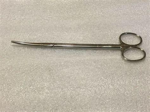

In [ ]:
image_path = Path('.')
#image_path = Path('Surgical_instruments/project/Merged/Surg100_200/train')

## images better in a folder
img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[201]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
# now using actual classes, not coco
import pandas as pd
df = pd.read_csv('Surgical_instruments/project/Merged/Surg100_200/_annotations.csv')
df.rename(columns = {'class':'label'},inplace=True)
classes = df.label.unique().tolist()
class_map = ClassMap(classes) ## resolved pickle error
len(class_map)

16

In [ ]:
## temporary
parser = parsers.COCOBBoxParser(
    annotations_filepath = Path('./_annotations_300.coco.json'),
    img_dir = Path('.', mask=False))

In [ ]:
#parser = parsers.COCOBBoxParser(
#    annotations_filepath = Path('./Surgical_instruments/project/Merged/Surg100_200/train/_annotations_.coco.json'),
#    img_dir = Path('./Surgical_instruments/project/Merged/Surg100_200/train', mask=False))

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/368 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/284 [00:00<?, ?it/s]

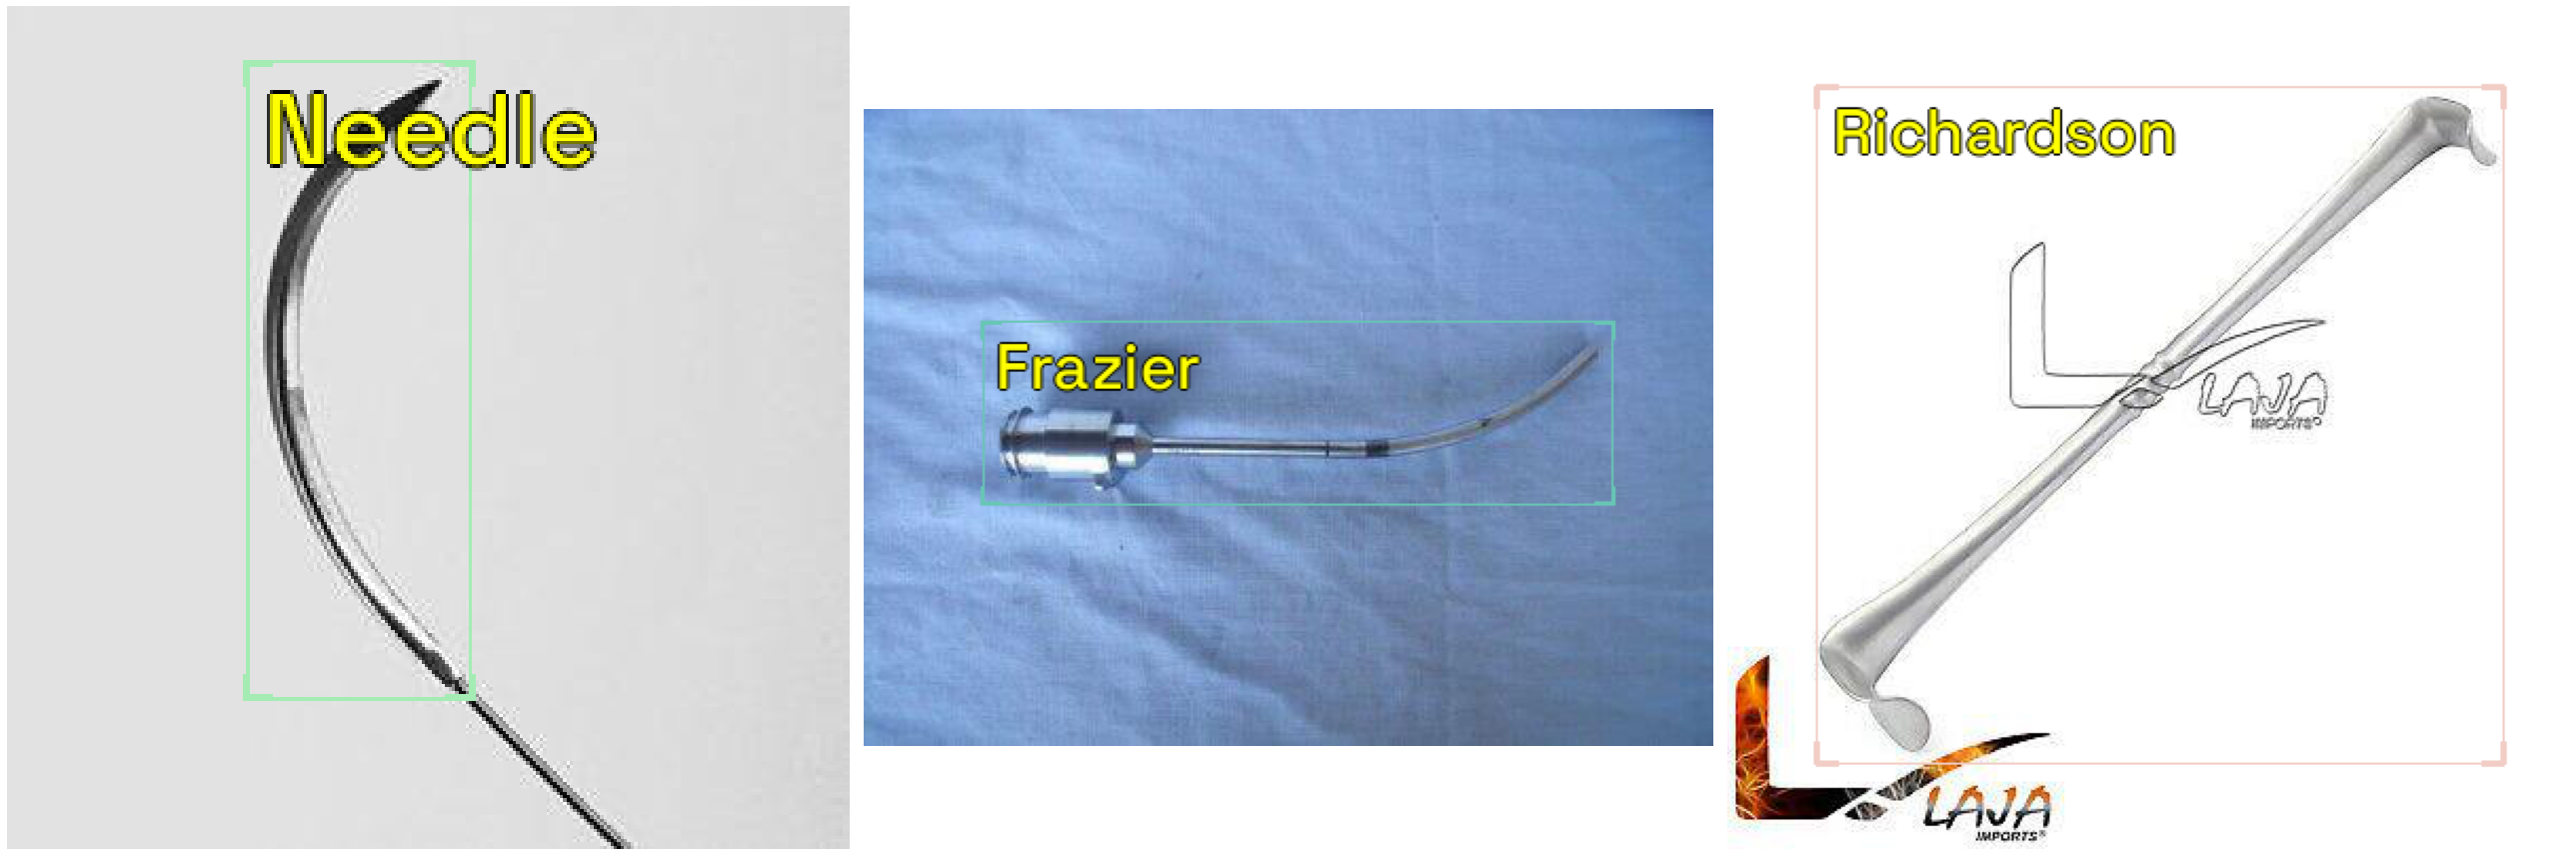

In [ ]:
show_records(train_records[200:203],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
from icevision.models.checkpoint import *

In [ ]:
model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extra_args) 

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

Generate inference for Surg400 using pretrained model

Fine tune VFnet using Surg100_300

In [ ]:
presize = 512
image_size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=image_size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

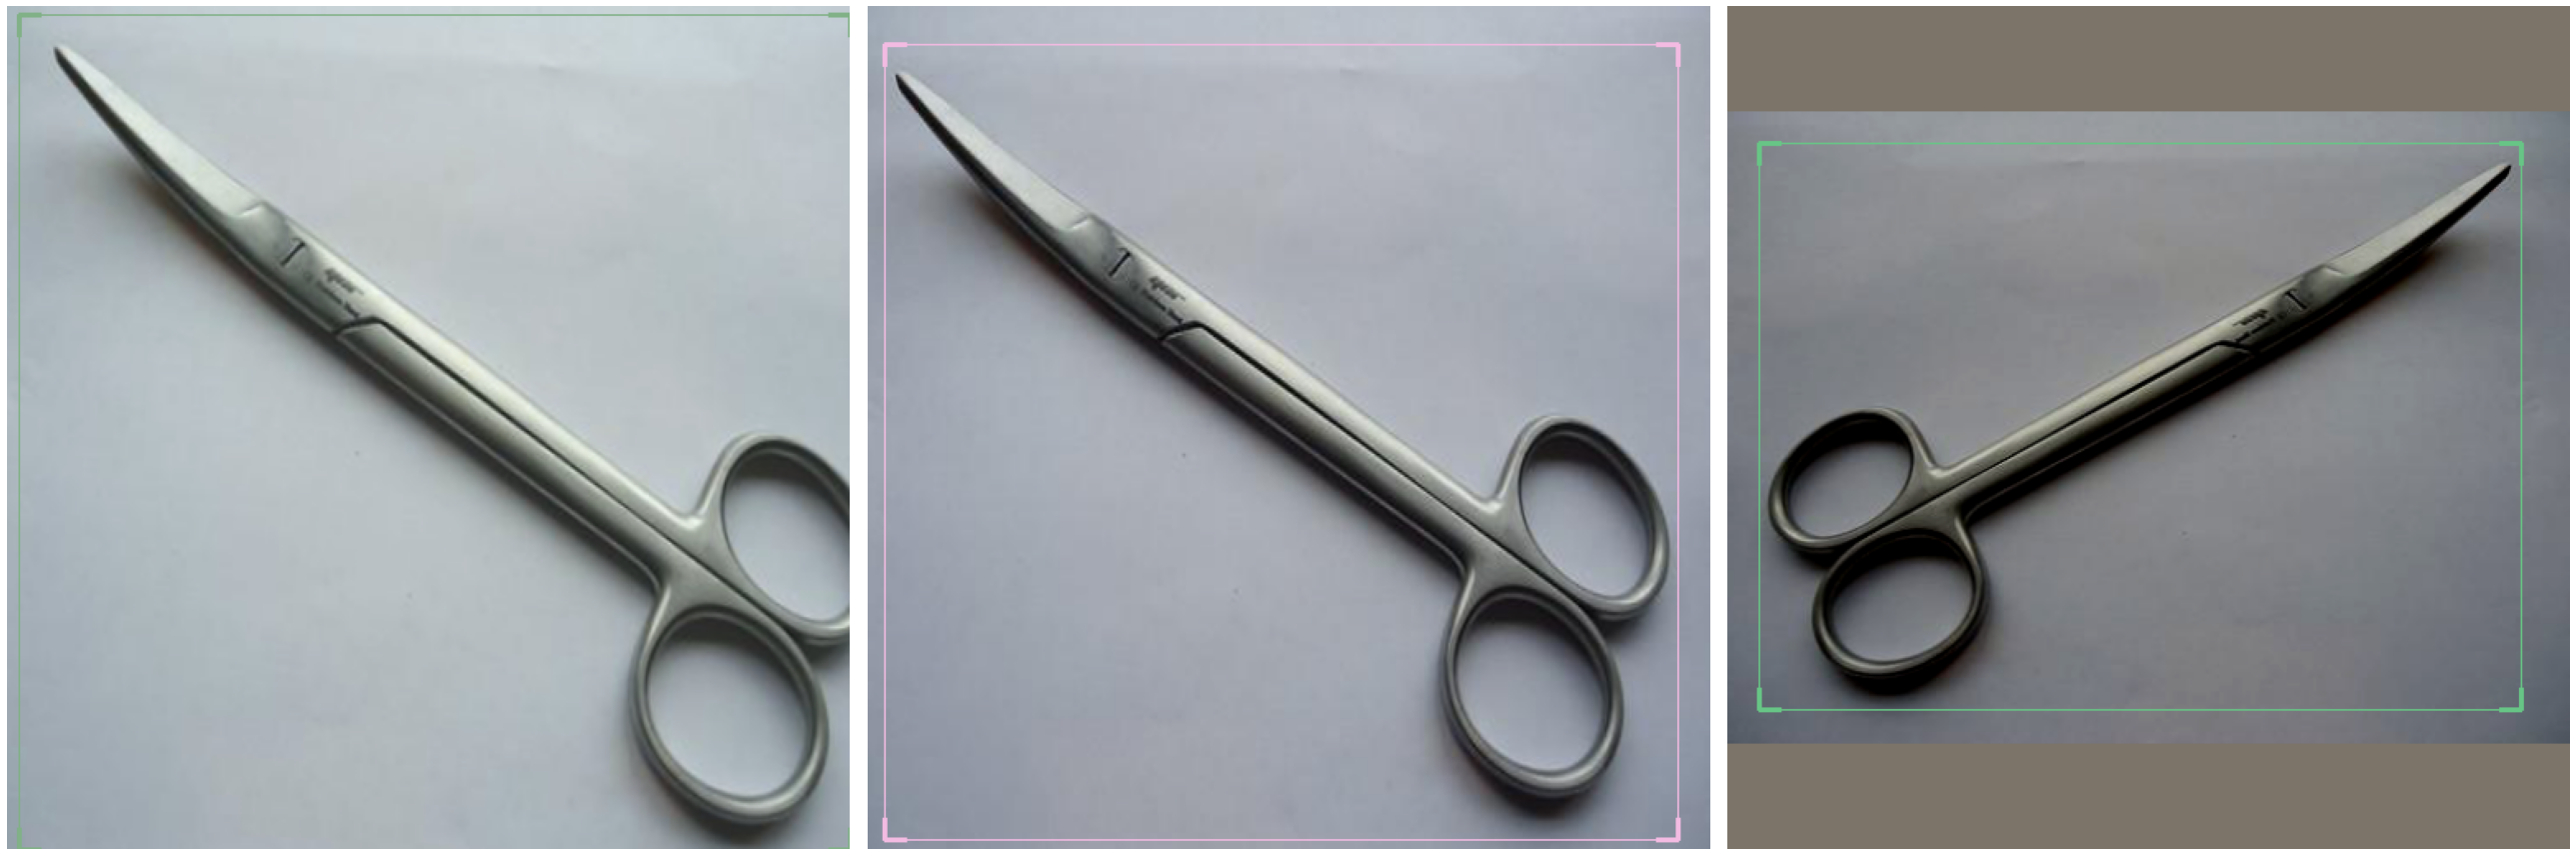

In [ ]:
samples = [train_ds[6] for _ in range(3)]
show_samples(samples, ncols=3, display_label=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x ##

model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(classes),)# **extr

In [ ]:
backbone.__dict__

{'config_path': Path('/root/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/vfnet/vfnet_r50_fpn_mstrain_2x_coco.py'),
 'model_name': 'vfnet',
 'pretrained': True,
 'weights_url': 'https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmdetection/v2.0/vfnet/vfnet_r50_fpn_mstrain_2x_coco/vfnet_r50_fpn_mstrain_2x_coco_20201027-7cc75bd2.pth'}

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4,
                               shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers = 4,
                               shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
learn = model_type.fastai.learner(dls = [train_dl, valid_dl],
                                  model = model, metrics = metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=0.0006918309954926372)

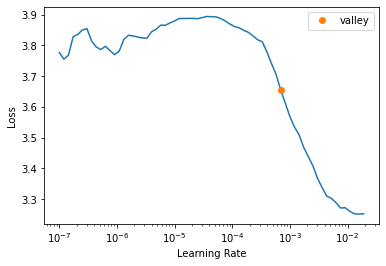

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(20, 0.0006918309954926372)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


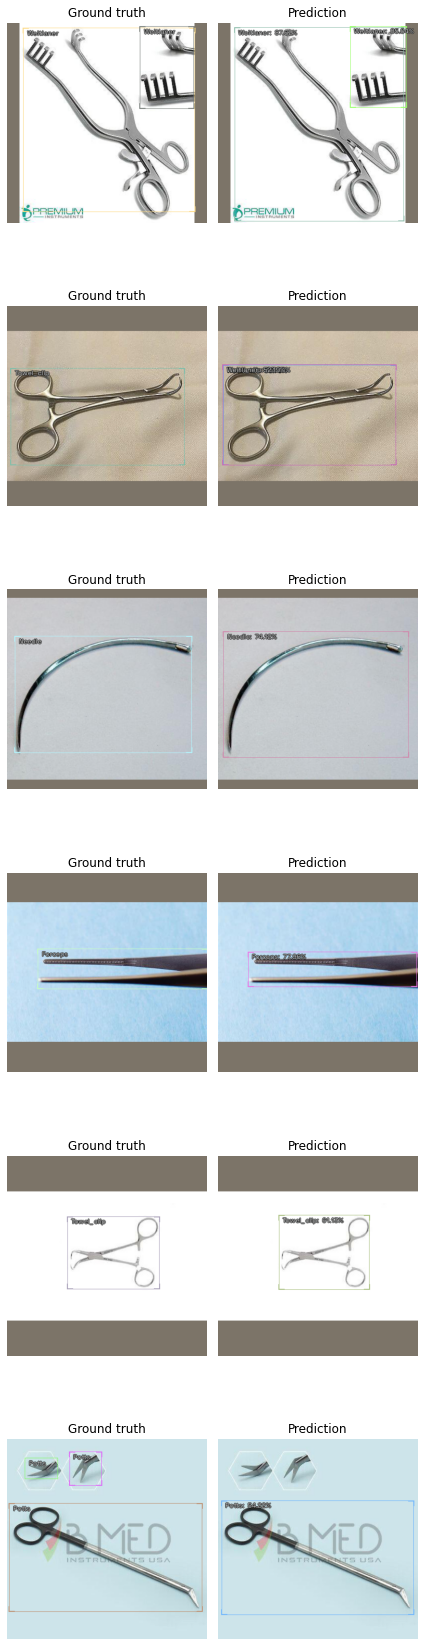

In [ ]:
model_type.show_results(model, valid_ds)

Good mAPs.

Do inference for Surg400.

In [ ]:
## temporary: uploaded in Colab
!ls Surg400

File00301.jpg  File00321.jpg  File00341.jpg  File00361.jpg  File00381.jpg
File00302.jpg  File00322.jpg  File00342.jpg  File00362.jpg  File00382.jpg
File00303.jpg  File00323.jpg  File00343.jpg  File00363.jpg  File00383.jpg
File00304.jpg  File00324.jpg  File00344.jpg  File00364.jpg  File00384.jpg
File00305.jpg  File00325.jpg  File00345.jpg  File00365.jpg  File00385.jpg
File00306.jpg  File00326.jpg  File00346.jpg  File00366.jpg  File00386.jpg
File00307.jpg  File00327.jpg  File00347.jpg  File00367.jpg  File00387.jpg
File00308.jpg  File00328.jpg  File00348.jpg  File00368.jpg  File00388.jpg
File00309.jpg  File00329.jpg  File00349.jpg  File00369.jpg  File00389.jpg
File00310.jpg  File00330.jpg  File00350.jpg  File00370.jpg  File00390.jpg
File00311.jpg  File00331.jpg  File00351.jpg  File00371.jpg  File00391.jpg
File00312.jpg  File00332.jpg  File00352.jpg  File00372.jpg  File00392.jpg
File00313.jpg  File00333.jpg  File00353.jpg  File00373.jpg  File00393.jpg
File00314.jpg  File00334.jpg  File0035

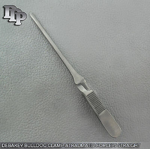

In [ ]:
image_path = Path('./Surg400')
#image_path = Path('Surgical_instruments/project/Merged/Surg100_200/train')

## images better in a folder
img_files = get_image_files(image_path)

img = PIL.Image.open(img_files[0]) ##
img = img.convert('RGB')

img.to_thumb(150,150)

In [ ]:
model.eval()

imgs_array = [PIL.Image.open(file) for file in img_files]

imgs_array = [image.convert('RGB') for image in imgs_array]

img_size = 384 

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)

In [ ]:
# generating pseudolabels
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)

preds_saved = model_type.predict_from_dl(model, infer_dl,
                                          keep_images=True,) 
## got can't pickle error which was resolved by using ClassMap

  0%|          | 0/25 [00:00<?, ?it/s]

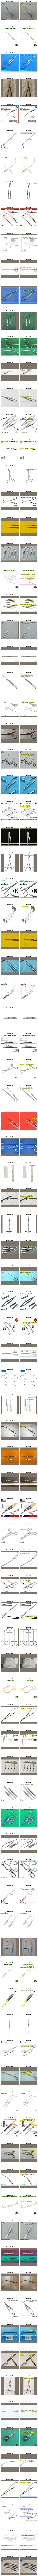

In [ ]:
show_preds(preds_saved, font_size=30, label_color='#ffff00')

Results: Some with reasonable bboxees.  Good weitlaner detection.

Use for pseudolabels.

In [68]:
#skip if predictions not good
for pred in preds_saved:
  pred.add_component(FilepathRecordComponent())

for _ in range(len(preds_saved)): 
  preds_saved[_].set_filepath(img_files[_]) 

conv = convert_preds_to_coco_style(preds_saved) 

In [69]:
#skip
add_info = {
    "info": {
    "description": "Surgery Instruments",
    "url": "http://cocodataset.org",
    "version": "1.0",
    "year": 2021,
    "contributor": "MR",
    "date_created": "2021/09/27"
    },
  "categories": [
                 ## adjusted to 80 classes, 
                 ## limiting categories
    {
      "supercategory": "kitchen",
      "id": 44,
      "name": "knife"
    },
    {
      "supercategory": "indoor",
      "id": 77,
      "name": "scissors"
    }
    ] }

In [70]:
#skip
annot = {**add_info, **conv}

f = open('annot.json','w') 
f.write(str(annot)) 
f.close()
## download and adjust ' to "
#### cannot see files in Colab

### alternate: go straight to Roboflow and google mount
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount = True)
#root_dir = Path('/content/gdrive/MyDrive')

In [ ]:
# temporary because colab doesn't show files
#from google.colab import files
#files.download('annot.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Retained codes for future use

In [ ]:
checkpoint_path = 'Surg100_vfnet.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet',## 
                        backbone_name='resnet50_fpn_mstrain_2x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

In [ ]:
!ls # with Surg100_ret_b.pth

annot.json   install_colab.sh	      sample_data	 Surg100_vfnet.pth
checkpoints  models		      Surg100_ret_b.pth  Surgical_instruments
gdrive	     pilot15_for_pseudolabel  Surg100_ret.pth
http:	     pilot15_ret.pth	      Surg100_vf_b.pth


In [ ]:
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

In [ ]:
# using finetune
model = checkpoint_and_model['model']
#model